In [133]:
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
%matplotlib inline

In [134]:
def print_csv(csv_file):
    #given a csv list, print the contents in a nice format
    for row in csv_file:
        print(row)

def clean_csv(csv_file):
    #given a csv list, remove the first row and return the list
    csv_file[:] = csv_file[1:]
    #replace Nan with 0
    for row in csv_file:
        for i in range(len(row)):
            if row[i] == 'NaN':
                row[i] = 0
    return convert_csv(csv_file)

def convert_csv(csv_file):
    #swap the rows and columns of the csv file past the first row
    #This simplifies accessing specific label data
    labels = csv_file[0]
    csv_file = list(zip(*csv_file[1:]))
    return labels, csv_file

def print_csv(labels, csv_file):
    #given a csv list, print the contents in a nice format
    for i in range(len(labels)):
        print(labels[i], csv_file[i])


In [135]:
folders = ["standup"]
data = []
path = ""
#data organized as data[folder_label][file][line][value]

#open csv files
for folder in folders:
    data.append([])
    #get all files in folder
    files = os.listdir(path + folder)
    for file in files:
        data[-1].append([])
        #open csv file
        with open(path + folder + "/" + file, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=';')
            for row in reader:
                data[-1][-1].append(row)

#clean data
for folder in range(len(data)):
    for file in range(len(data[folder])):
        data[folder][file] = clean_csv(data[folder][file])

# print_csv(data[0][0][0], data[0][0][1]) #test print


['ACCELEROMETER X (m/sÂ²)', 'ACCELEROMETER Y (m/sÂ²)', 'ACCELEROMETER Z (m/sÂ²)', 'GRAVITY X (m/sÂ²)', 'GRAVITY Y (m/sÂ²)', 'GRAVITY Z (m/sÂ²)', 'LINEAR ACCELERATION X (m/sÂ²)', 'LINEAR ACCELERATION Y (m/sÂ²)', 'LINEAR ACCELERATION Z (m/sÂ²)', 'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)', 'LIGHT (lux)', 'MAGNETIC FIELD X (Î¼T)', 'MAGNETIC FIELD Y (Î¼T)', 'MAGNETIC FIELD Z (Î¼T)', 'ORIENTATION Z (azimuth Â°)', 'ORIENTATION X (pitch Â°)', 'ORIENTATION Y (roll Â°)', 'PROXIMITY (i)', 'ATMOSPHERIC PRESSURE (hPa)', 'SOUND LEVEL (dB)', 'LOCATION Latitude : ', 'LOCATION Longitude : ', 'LOCATION Altitude ( m)', 'LOCATION Altitude-google ( m)', 'LOCATION Altitude-atmospheric pressure ( m)', 'LOCATION Speed ( Kmh)', 'LOCATION Accuracy ( m)', 'LOCATION ORIENTATION (Â°)', 'Satellites in range', 'Time since start in ms ', 'YYYY-MO-DD HH-MI-SS_SSS']
Time since start in ms  ('27', '527', '1027', '1527', '2027', '2527', '3028')


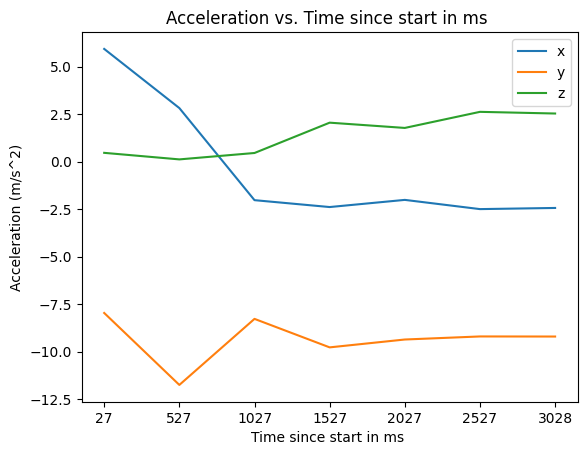

In [136]:
#plot a random file
file_index = np.random.randint(0, len(data[0]))
file = data[0][file_index]

print(file[0]) #print labels
x_label = file[0][-2]
x = file[1][-2]
print(x_label, x)

#plot the data, accel x,y,z (0,1,2) and convert to floats
plt.plot(x, [float(i) for i in file[1][0]], label="x")
plt.plot(x, [float(i) for i in file[1][1]], label="y")
plt.plot(x, [float(i) for i in file[1][2]], label="z")

plt.xlabel(x_label)
plt.ylabel("Acceleration (m/s^2)")
plt.title("Acceleration vs. " + x_label)
plt.legend(["x", "y", "z"])
plt.show()
